# Predicción de ingreso hospitalario en urgencias (clasificación binaria)
Objetivo: predecir ingreso (sí/no) usando variables demográficas, signos vitales y triage.
Relevancia clínica: priorizar recall en “Ingreso” para no dejar pasar pacientes graves.
Decisión de outcome: Disposition 1/4/6 = Egreso (0), 2/3/5/7 = Ingreso (1).

Dataset extraído desde https://www.kaggle.com/datasets/ilkeryildiz/emergency-service-triage-application/data

In [50]:
# =============== 2) Imports, configuración y reproducibilidad ===============
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings; warnings.filterwarnings("ignore")
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import sklearn
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)



Python: 3.13.5
pandas: 2.3.2
numpy: 2.3.3
sklearn: 1.7.2


## Datos
Fuente: CSV provisto (latin-1, separador ;).
Notas: varias variables numéricas venían como texto; varias categóricas son códigos (diccionario adjunto).

Dimensiones: (1267, 24)
Columnas: ['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode', 'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED', 'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage']


,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,...,36.6,100,2,Corneal abrasion,1,4,2,86,"5,00",1
1,1,1,56,12,3,2,right forearm burn,1,1,2,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Group,1267.0,NaN,NaN,NaN,1.456985,0.498343,1.0,1.0,1.0,2.0,2.0
Sex,1267.0,NaN,NaN,NaN,1.521705,0.499726,1.0,1.0,2.0,2.0,2.0
Age,1267.0,NaN,NaN,NaN,54.423836,19.725033,16.0,37.0,57.0,71.0,96.0
Patients number per hour,1267.0,NaN,NaN,NaN,7.519337,3.160563,1.0,5.0,7.0,10.0,17.0
Arrival mode,1267.0,NaN,NaN,NaN,2.820837,0.807904,1.0,2.0,3.0,3.0,7.0
Injury,1267.0,NaN,NaN,NaN,1.192581,0.394482,1.0,1.0,1.0,1.0,2.0
Chief_complain,1267,417,abd pain,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mental,1267.0,NaN,NaN,NaN,1.105762,0.447768,1.0,1.0,1.0,1.0,4.0
Pain,1267.0,NaN,NaN,NaN,0.563536,0.496143,0.0,0.0,1.0,1.0,1.0
NRS_pain,1267,11,#BOÞ!,556,NaN,NaN,NaN,NaN,NaN,NaN,NaN


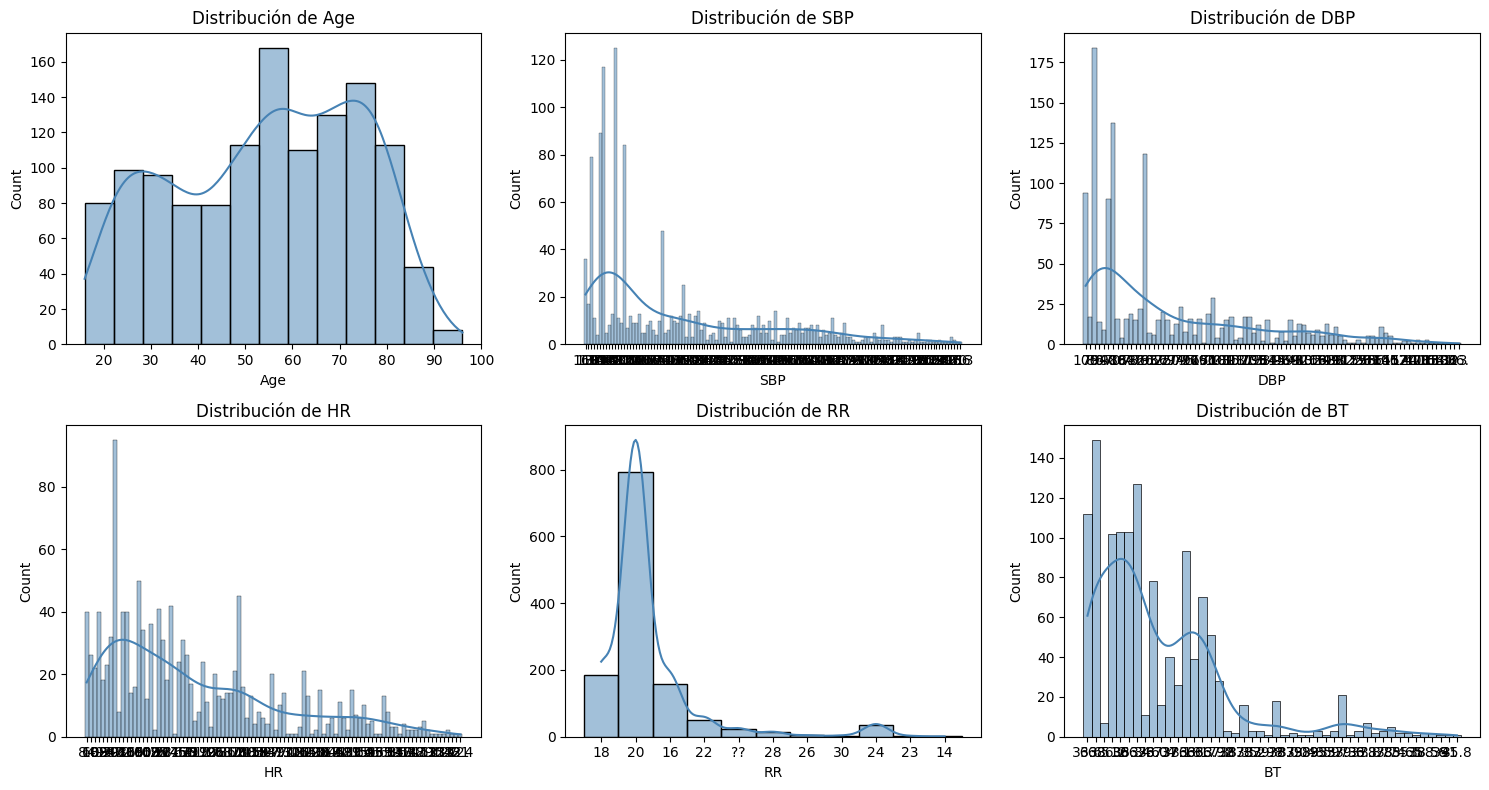

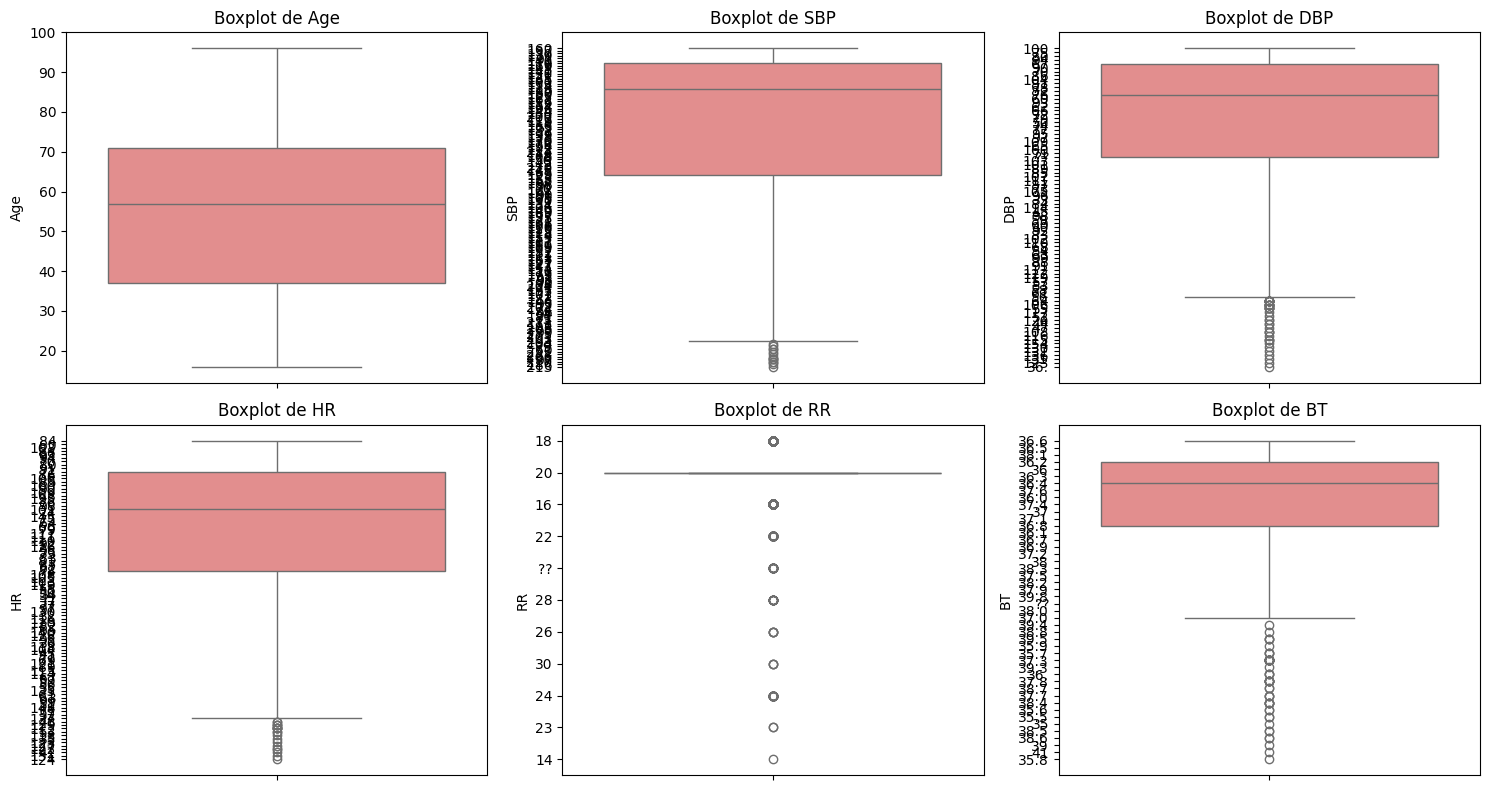

In [63]:
# =============== 4) Carga del dataset + EDA inicial ===============
DATA_PATH = "data/data.csv"   # <<-- ajusta si tu archivo se llama distinto
df = pd.read_csv(DATA_PATH, encoding="latin-1", sep=";")

print("Dimensiones:", df.shape)
print("Columnas:", df.columns.tolist())
display(df.head(3))

# Estadística descriptiva
display(df.describe(include="all").T)

# =============================
# Gráficos iniciales: histogramas y boxplots de las variables predictoras
# =============================
import seaborn as sns
import matplotlib.pyplot as plt

# Lista preliminar de posibles predictoras (antes del feature engineering)
predictoras = ["Age","SBP","DBP","HR","RR","BT"]

# Histogramas
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(predictoras):
    sns.histplot(df[col], kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(predictoras):
    sns.boxplot(y=df[col], ax=axes[i], color="lightcoral")
    axes[i].set_title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()



## Diccionario resumido (categóricas codificadas)

Sex: 1=Femenino, 2=Masculino

Injury: 1=No, 2=Sí

Pain: 0=No, 1=Sí

Mental: 1=Alert, 2=Verbal, 3=Pain response, 4=Unresponsive

Group: 1=Local ED (3°), 2=Regional ED (4°)

Arrival mode: 1=Walking, 2=Public Ambulance, 3=Private Vehicle, 4=Private Ambulance, 5–7=Other

KTAS_RN/KTAS_expert: 1–5 (1–3 emergencias; 4–5 no emergencias)

Disposition: 1=Discharge, 2=Ward, 3=ICU, 4=Discharge, 5=Transfer, 6=Death, 7=Surgery.

In [65]:
# =============== 6) Conversión de tipos + ingeniería de atributos ===============
# A) Forzar a numérico variables mal tipadas
num_like = ["NRS_pain","SBP","DBP","HR","RR","BT","Saturation","KTAS duration_min"]
for col in num_like:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# B) Crear objetivo binario: Admitted (0=Egreso: {1,4,6}; 1=Ingreso: {2,3,5,7})
df["Admitted"] = df["Disposition"].apply(lambda x: 0 if x in [1,4,6] else 1)

# C) Feature engineering clínico
df["MAP"] = (df["SBP"] + 2*df["DBP"]) / 3
df["Hypotension"] = (df["SBP"] < 90).astype(int)
df["Tachycardia"] = (df["HR"] > 120).astype(int)
df["Resp_abnormal"] = ((df["RR"] < 12) | (df["RR"] > 24)).astype(int)
df["Fever_or_Hypothermia"] = ((df["BT"] > 38) | (df["BT"] < 35)).astype(int)
df["Elderly"] = (df["Age"] >= 65).astype(int)

print("Distribución Admitted:\n", df["Admitted"].value_counts())



Distribución Admitted:
 Admitted
0    832
1    435
Name: count, dtype: int64


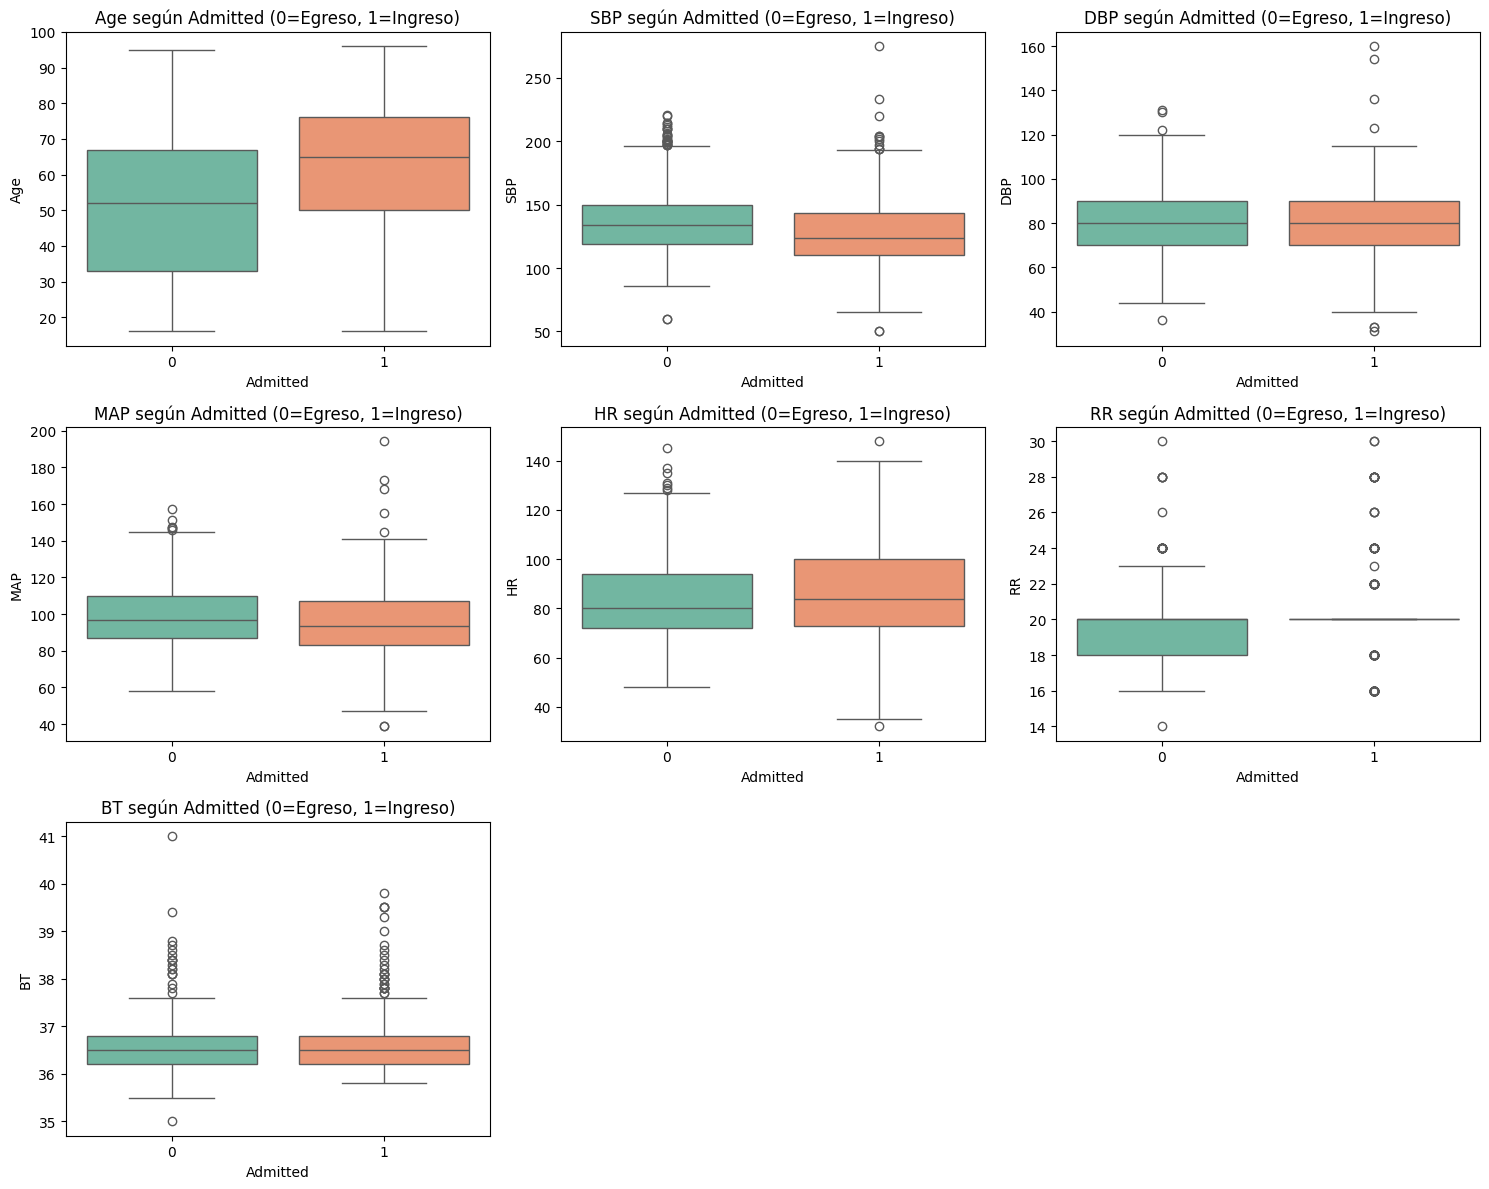

In [67]:
# =============== 7bis) Boxplots de predictoras vs Admitted ===============
import seaborn as sns

predictoras = ["Age","SBP","DBP","MAP","HR","RR","BT"]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 9 espacios
axes = axes.flatten()

for i, col in enumerate(predictoras):
    sns.boxplot(x="Admitted", y=col, data=df, ax=axes[i], palette="Set2")
    axes[i].set_title(f"{col} según Admitted (0=Egreso, 1=Ingreso)")

# Eliminar ejes sobrantes
for j in range(len(predictoras), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## EDA breve y valores faltantes

Porcentaje de nulos en signos vitales (1–2%), Saturation (>50%) y KTAS duration_min (100%).

Decisión: descartar Saturation, KTAS duration_min, NRS_pain (nulos masivos).

Outliers: mantener por plausibilidad clínica (no winsorizamos).

Imputación con mediana en numéricas y moda en categóricas.

In [58]:
# =============== 8) Limpieza: descartar columnas con nulos masivos ===============
for dropcol in ["Saturation", "KTAS duration_min", "NRS_pain"]:
    if dropcol in df.columns:
        df.drop(columns=dropcol, inplace=True)

# Variables numéricas finales
num_vars = ['Age','SBP','DBP','MAP','HR','RR','BT',
            'Hypotension','Tachycardia','Resp_abnormal','Fever_or_Hypothermia','Elderly']

# Variables categóricas (codificadas con dígitos, pero tratadas como categorías)
cat_vars = ['Sex','Group','Arrival mode','Injury','Pain','Mental','KTAS_RN','KTAS_expert']

target = "Admitted"
X = df[num_vars + cat_vars].copy()
y = df[target].copy()

print("Num vars:", num_vars)
print("Cat vars:", cat_vars)


Num vars: ['Age', 'SBP', 'DBP', 'MAP', 'HR', 'RR', 'BT', 'Hypotension', 'Tachycardia', 'Resp_abnormal', 'Fever_or_Hypothermia', 'Elderly']
Cat vars: ['Sex', 'Group', 'Arrival mode', 'Injury', 'Pain', 'Mental', 'KTAS_RN', 'KTAS_expert']


## Partición de datos
Split 80/20 estratificado por Admitted (para mantener proporción de clases).

In [59]:
# =============== 10) Split y preprocesamiento ===============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_vars),
    ("cat", cat_pipe, cat_vars)
])


## Modelo principal: Regresión Logística
Elegimos recall de Ingreso como métrica prioritaria (seguridad del paciente).
Reportamos: precision, recall, f1, accuracy y matriz de confusión.


              precision    recall  f1-score   support

           0       0.83      0.75      0.79       167
           1       0.59      0.70      0.64        87

    accuracy                           0.73       254
   macro avg       0.71      0.72      0.71       254
weighted avg       0.75      0.73      0.74       254



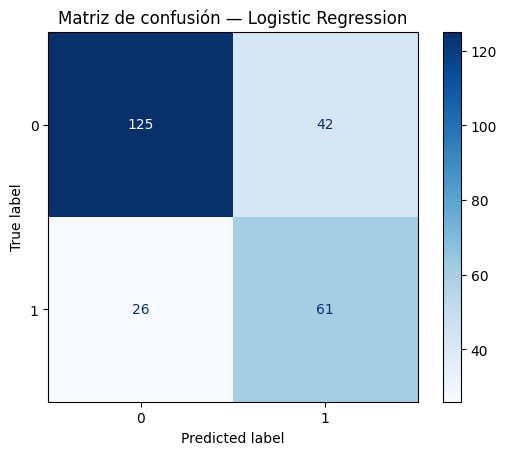

In [60]:
# =============== 12) Entrenamiento y evaluación ===============
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)

pipe_log = Pipeline([
    ("preproc", preprocessor),
    ("model", log_reg)
])

pipe_log.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión — Logistic Regression")
plt.show()


## Interpretabilidad
Coeficientes en OR (exp(coef)). OR>1 → aumenta chance de ingreso; OR<1 la reduce.
Forest plot (escala log) y guardado en figs/.

,Variable,Coef,OddsRatio,logOR_abs
40,KTAS_expert_5,-1.285479,0.276518,1.285479
3,MAP,-1.071824,0.342384,1.071824
19,Arrival mode_4,0.860508,2.364360,0.860508
22,Arrival mode_7,-0.803406,0.447801,0.803406
34,KTAS_RN_4,-0.677041,0.508118,0.677041
35,KTAS_RN_5,-0.669542,0.511943,0.669542
14,Group_1,-0.640708,0.526919,0.640708
2,DBP,0.612809,1.845609,0.612809
32,KTAS_RN_2,0.570366,1.768914,0.570366
36,KTAS_expert_1,0.551282,1.735476,0.551282


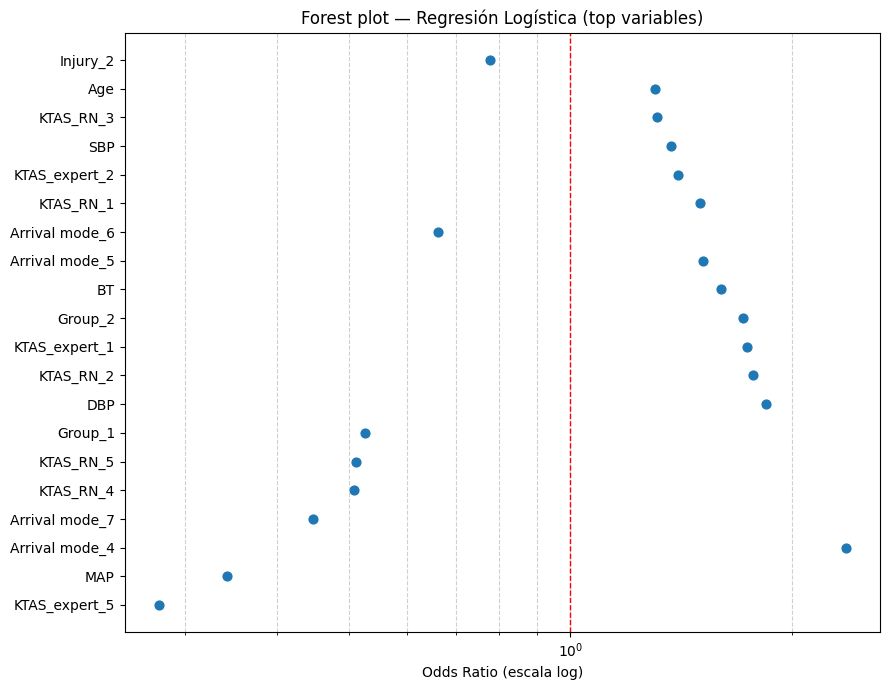

Guardado en: figs\forestplot_logreg_top20.png


In [61]:
# =============== 14) OR y forest plot ===============
from pathlib import Path

# Nombres de columnas después de OHE
ohe = pipe_log.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
cat_out = ohe.get_feature_names_out(cat_vars).tolist()
feat_names = list(num_vars) + cat_out

# Coeficientes y OR
coefs = pipe_log.named_steps['model'].coef_[0]
odds = np.exp(coefs)

importance = pd.DataFrame({"Variable": feat_names, "Coef": coefs, "OddsRatio": odds})
importance["logOR_abs"] = np.abs(np.log(importance["OddsRatio"]))
imp_top = importance.sort_values("logOR_abs", ascending=False).head(20)

display(importance.sort_values("logOR_abs", ascending=False).head(10))

# Forest plot
outdir = Path("figs"); outdir.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots(figsize=(9,7))
ypos = np.arange(len(imp_top))
ax.scatter(imp_top["OddsRatio"], ypos, s=40)
ax.axvline(1, color="red", linestyle="--", linewidth=1)
ax.set_yticks(ypos, labels=imp_top["Variable"])
ax.set_xscale("log")
ax.set_xlabel("Odds Ratio (escala log)")
ax.set_title("Forest plot — Regresión Logística (top variables)")
ax.grid(True, which="both", axis="x", linestyle="--", alpha=0.6)
fig.tight_layout()
save_path = outdir / "forestplot_logreg_top20.png"
fig.savefig(save_path, dpi=180, bbox_inches="tight")
plt.show()
print("Guardado en:", save_path)


## Verificación del escalado
Comprobamos que numéricas queden con media≈0 y desvío≈1 tras el preprocesamiento.

In [62]:
# =============== 16) Verificación del escalado (opcional) ===============
X_train_transformed = preprocessor.fit_transform(X_train)
all_feature_names = list(num_vars) + cat_out
X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_train_df[num_vars].describe().T[['mean','std']]


,mean,std
Age,1.323938e-16,1.000494
SBP,2.595270e-16,1.000494
DBP,-1.753561e-17,1.000494
MAP,5.611394e-16,1.000494
HR,6.137462e-17,1.000494
RR,-1.683418e-16,1.000494
BT,-2.155126e-15,1.000494
Hypotension,-2.454985e-17,1.000494
Tachycardia,-2.630341e-17,1.000494
Resp_abnormal,1.052136e-17,1.000494


## Limitaciones y próximos pasos

Variables con nulos masivos descartadas (evitar sesgos).

Texto libre no modelado (Chief_complain, Diagnosis) → mejora futura con NLP/TF-IDF.

Clase 1 (Ingresos) menor que 0 → balance por class_weight="balanced".

Explorar calibración de probas y umbrales (curva PR / ROC).

(Opcional) Comparar con RandomForest y SMOTE.
